# k-Nearest Neighbor (kNN) 练习

*完成并提交此完成的工作表（包括其输出以及工作表外的任何支持代码）作为作业提交的一部分。有关更多详细信息，请参阅课程网站上的 [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html)。*

kNN 分类器包括两个阶段：

- **训练阶段**：分类器接收训练数据并简单地记住它。  
- **测试阶段**：kNN 通过与所有训练图像比较，对每个测试图像进行分类，并传递最相似的 k 个训练样本的标签。  
- k 的值通过交叉验证确定。

在本次练习中，您将实现这些步骤，理解基本的图像分类流程，学习交叉验证，并掌握编写高效向量化代码的技巧。

<details>
<summary>English Version</summary>

# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

</details>


In [25]:
# 初始化

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# 让我们施加一些魔法让matplotib的图标能在notebook中加载而不是新开一个窗口
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 另外一些魔法让笔记本能够重载py模块
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# 加载数据集
cifar10_dir = "cs231n/datasets/cifar-10-batches-py"

# 清理之前加载的变量以防止多次加载(可能会导致内存问题)
try:
    del X_train, y_train  # type: ignore
    del X_test, y_test  # type: ignore
    print("Clear previously loaded data.")
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print("Training data shape: ", X_train.shape)
print("Training labels shape: ", y_train.shape)
print("Test data shape: ", X_test.shape)
print("Test labels shape: ", y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


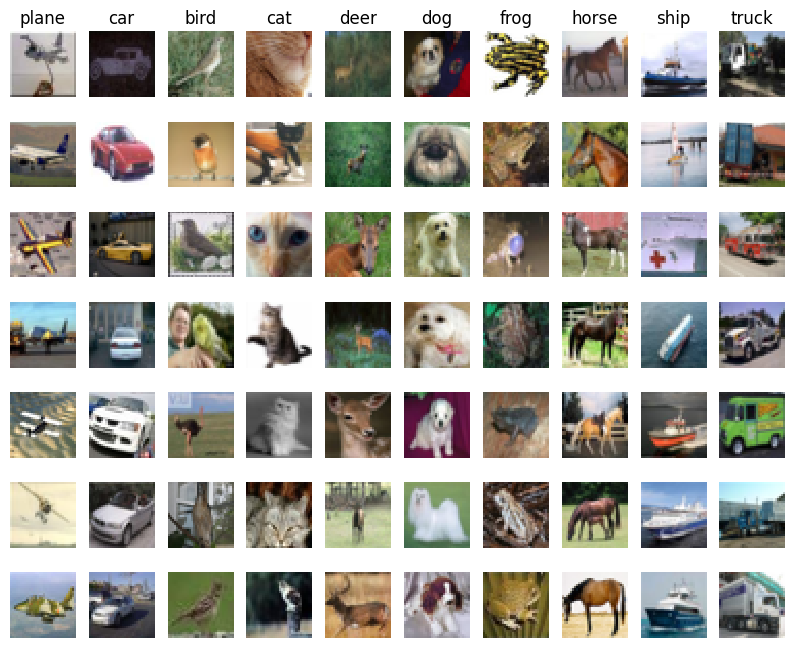

In [27]:

# 可视化一些数据集的样例，显示每个类的一些例子

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)


samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [28]:
# 减少数据量以更快执行代码
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# 把这些图像矩阵变成一行
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [29]:
from cs231n.classifiers import KNearestNeighbor

# 创建KNN分类器 , 这个分类器是个菜鸟,只记住数据并不会做更多的预处理
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

我们现在希望使用 kNN 分类器对测试数据进行分类。回想一下，这一过程可以分为两个步骤：

1. 首先，我们需要计算所有测试样本与所有训练样本之间的距离。
2. 在获得这些距离后，对于每个测试样本，我们找到距离最近的 \(k\) 个样本，并通过它们的投票决定标签。

让我们先从计算所有训练样本与测试样本之间的距离矩阵开始。例如，如果有 ($N_{\text{tr}}$) 个训练样本和 ($N_{\text{te}}$) 个测试样本，这个阶段应生成一个 ($N_{\text{te}} \times N_{\text{tr}}$) 的矩阵，其中每个元素 $((i, j))$ 是第 $(i)$ 个测试样本与第 $(j)$ 个训练样本之间的距离。

**注意：在本 notebook 中实现的三个距离计算中，你不能使用 numpy 提供的 `np.linalg.norm()` 函数。**

首先，打开 `cs231n/classifiers/k_nearest_neighbor.py` 文件，并实现函数 `compute_distances_two_loops`。该函数使用一个（非常低效的）双重循环，逐个计算所有（测试样本，训练样本）对之间的距离矩阵中的元素。

In [30]:
# 打开文件 cs231n/classifiers/k_nearest_neighbor.py 并完成接口compute_distances_two_loops
# 构造一个500 x 5000的矩阵 对应的元素是欧式距离(L2)
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 3072)
(5000, 3072)
(500, 5000)


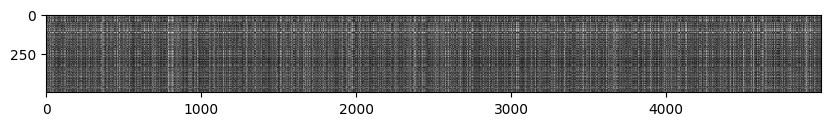

In [31]:
# 我们可以可视化距离矩阵,每行是一个测试例子
plt.imshow(dists, interpolation='none')
plt.show()

**问题 1**

注意距离矩阵中的结构化模式，其中某些行或列明显更亮。（注意，在默认的颜色方案中，黑色表示较低的距离，而白色表示较高的距离。）

- 数据中是什么原因导致了这些明显明亮的行？
- 又是什么原因导致了这些明亮的列？

$\color{blue}{\textit Your Answer:}$ 
    深色的列表示距离小，即更相似

<details>
<summary>English Version</summary>

**Inline Question 1**
Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$ *fill this in.*

</details>


In [32]:
# 完成接口predict_labels 并运行下面的代码
# 使用 k=1
y_test_pred = classifier.predict_labels(dists, k=1)
# 计算并打印正确预测的样例
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('%d / %d 正确 => 正确率: %f' % (num_correct, num_test, accuracy))

137 / 500 正确 => 正确率: 0.274000


您应该预期看到大约 `27%` 的准确率。现在让我们尝试一个更大的 `k` 值，例如 `k = 5`：

<details>
<summary>English Version</summary>

You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

</details>

In [33]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('%d / %d 正确 => 正确率: %f' % (num_correct, num_test, accuracy))

139 / 500 正确 => 正确率: 0.278000


这应该会比`k=1`要好
<details>
<summary>English Version</summary>
You should expect to see a slightly better performance than with `k = 1`.

</details>

**Inline Question 2**

我们也可以使用其他距离度量，例如 L1 距离。  
对于某张图像 $I_k$ 在位置 $(i,j)$ 的像素值 $p_{ij}^{(k)}$，  
所有图像上所有像素的均值 $\mu$ 定义为：
$$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$  
所有图像上逐像素的均值 $\mu_{ij}$ 定义为：
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$  
总体标准差 $\sigma$ 和逐像素标准差 $\sigma_{ij}$ 的定义类似。

以下哪种预处理步骤不会改变使用 L1 距离的最近邻分类器的性能？请选择所有适用项。为明确起见，训练和测试样本均以相同方式进行预处理。

1. 减去均值 $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$)。  
2. 减去逐像素均值 $\mu_{ij}$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$)。  
3. 减去均值 $\mu$ 并除以标准差 $\sigma$。  
4. 减去逐像素均值 $\mu_{ij}$ 并除以逐像素标准差 $\sigma_{ij}$。  
5. 旋转数据的坐标轴，即将所有图像旋转相同的角度。旋转导致的图像空白区域用相同的像素值填充，且不进行插值。

$\color{blue}{\textit Your Answer:}$

$\color{blue}{\textit Your Explanation:}$

<details>
<summary>English Version</summary>

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$,

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply. To clarify, both training and test examples are preprocessed in the same way.

1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data, which means rotating all the images by the same angle. Empty regions in the image caused by rotation are padded with a same pixel value and no interpolation is performed.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$

</details>


In [34]:
# 现在让我们用单层循环来加速距离矩阵的计算
# 完成接口compute_distances_one_loop 并运行下面的代码
dists_one = classifier.compute_distances_one_loop(X_test)

# 为确保我们的向量化实现是正确的，我们需要确保它与之前的实现一致。
# 判断两个矩阵是否相似的方法有很多；其中最简单的方法之一是使用 Frobenius 范数。
# 如果您之前没有见过，Frobenius 范数是指两个矩阵所有元素差值的平方和的平方根；
# 换句话说，将矩阵重塑为向量并计算它们之间的欧几里得距离。
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('相似度: %f' % (difference, ))
if difference < 0.001:
    # print('Good! The distance matrices are the same')
    print('Good! 距离矩阵相同')
else:
    # print('Uh-oh! The distance matrices are different')
    print('Uh-oh! 距离矩阵不同')

相似度: 0.000000
Good! 距离矩阵相同


In [35]:
# 现在实现完全向量化的版本并运行代码,完成接口compute_distances_no_loops,并运行下面的代码
dists_two = classifier.compute_distances_no_loops(X_test)

# 计算两个矩阵是否相似
difference = np.linalg.norm(dists - dists_two, ord='fro')
# print('No loop difference was: %f' % (difference, ))
print('相似度: %f' % (difference, ))
if difference < 0.001:
    # print('Good! The distance matrices are the same')
    print('Good! 距离矩阵相同')
else:
    # print('Uh-oh! The distance matrices are different')
    print('Uh-oh! 距离矩阵不同')

相似度: 0.000000
Good! 距离矩阵相同


In [36]:
# 让我们比较不同实现的速度
def time_function(f, *args):
    """
    执行函数f并返回执行所需的时间(秒)
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('两层循环版本花费 %f 秒' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('一层循环版本花费 %f 秒' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('无循环版本花费 %f 秒' % no_loop_time)

# 你应该能明显的看到完全向量化的实现速度更快!
# 注意: 根据你的机器,你可能在从两层循环到一层循环时看不到加速,甚至会变慢


(500, 3072)
(5000, 3072)
两层循环版本花费 15.819924 秒
一层循环版本花费 35.866314 秒
无循环版本花费 0.135997 秒


### 交叉验证

我们已经实现了 k-最近邻分类器，但我们将 k 的值设为 5 是任意的。现在我们将通过交叉验证来确定这个超参数的最佳值。

<details>
<summary>English Version</summary>

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

</details>


In [37]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
# TODO:
# 将训练数据拆分成若干个折叠。拆分后,X_train_folds 和 y_train_folds 应该都是长度为 num_folds 的列表
# 其中 y_train_folds[i] 是 X_train_folds[i] 中点的标签向量
# 提示: 查看numpy的array_split函数
# numpy.array_split(ary, indices_or_sections, axis=0)
# ary：需要拆分的数组。
# indices_or_sections：如果是一个整数，表示要拆分的子数组数量；如果是一个整数序列，则它表示每个拆分点处的索引。
# axis：沿哪个轴进行拆分，默认为0，即第一个轴。

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


# 这个字典保存我们在运行交叉验证时找到的不同 k 值的准确率。
# 运行交叉验证后，k_to_accuracies[k] 应该是一个长度为 num_folds 的列表，
# 其中包含我们在使用该 k 值时找到的不同准确率值。
k_to_accuracies = {}

# TODO: 执行 k 折交叉验证以找到最佳的 k 值。对于每个可能的 k 值，运行 KNN算法 num_folds 次，
# 每次使用除了一个折叠之外的所有折叠作为训练数据，将最后一个折叠作为验证集。
# 将所有折叠和所有 k 值的准确率存储在 k_to_accuracies 字典中。
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for k in k_choices:
    print(f"正在计算k={k}")
    k_to_accuracies[k] = []
    for i in range(num_folds):
        # 选择第i个分片为验证集，其他数据为训练数据
        temp_train_x = np.concatenate(
            np.compress(
                [False if temp_i == i else True for temp_i in range(num_folds)],
                X_train_folds,
                axis=0,
            )
        )
        temp_train_y = np.concatenate(
            np.compress(
                [False if temp_i == i else True for temp_i in range(num_folds)],
                y_train_folds,
                axis=0,
            )
        )

        # 训练数据
        classifier.train(temp_train_x, temp_train_y)

        # 获取预测
        temp_pred_y = classifier.predict(X_train_folds[i], k=k, num_loops=0)

        # 计算准确率
        correct_count = np.sum(temp_pred_y == y_train_folds[i])
        k_to_accuracies[k].append(correct_count / len(temp_pred_y))


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# 输出结果
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print("k = %d, accuracy = %f" % (k, accuracy))

正在计算k=1
正在计算k=3
正在计算k=5
正在计算k=8
正在计算k=10
正在计算k=12
正在计算k=15
正在计算k=20
正在计算k=50
正在计算k=100
k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, a

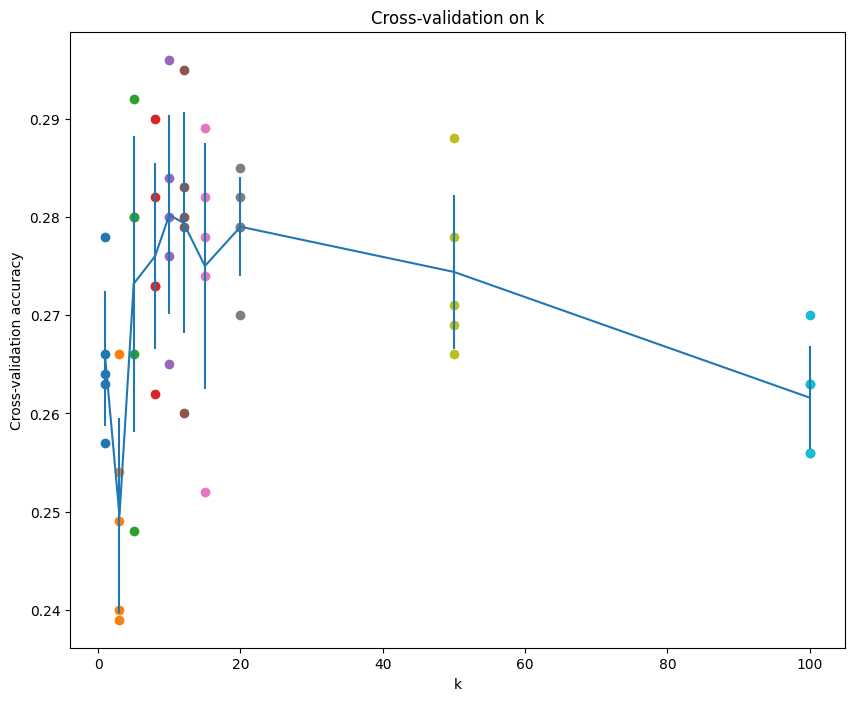

In [38]:
# 绘制原始观察结果
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# 绘制趋势线，误差条对应标准差
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [39]:
# 基于上面的交叉验证结果，选择最佳的 k 值，使用所有的训练数据重新训练分类器，并在测试数据上进行测试。
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# 计算并显示准确率
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


**Inline Question 3**

以下关于 $k$-最近邻分类器 ($k$-NN) 的陈述在分类设置中，对于所有 $k$ 是否正确？请选择所有适用项。  
1. k-NN 分类器的决策边界是线性的。  
2. 1-NN 的训练误差总是小于或等于 5-NN 的训练误差。  
3. 1-NN 的测试误差总是小于 5-NN 的测试误差。  
4. 使用 k-NN 分类器对测试样本进行分类所需的时间随着训练集的大小增长。  
5. 以上皆不正确。  

$\color{blue}{\textit 你的答案是:}$ 5

$\color{blue}{\textit 解释:}$ k的取值是需要根据实际情况来确定的

<details>
<summary>English Version</summary>

**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$

</details>